In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import glob

from scipy.interpolate import make_lsq_spline, BSpline
from scipy.interpolate import BSpline, make_interp_spline

In [17]:
#Glob away all the fits in a dir
fits_list = glob.glob("/home/kevin/aufklarung_astro_station/sdss_spectra/sky_flux/sdss_fits_files/*.fits") #"/home/kevin/WORK/coding/sdsswork/sdss_spectra/sky_flux/sdss_fits_files/*.fits")
 #glob.glob("sdss_fits_files/*.fits")

#Extra the fits tables from all the globbed fits
specdata_list=[]
for i in fits_list:
    with fits.open(i) as fit_file:
        specdata=fit_file[1].data
        header=fit_file[0].header
        specdata_list.append(specdata)


#Get the shapes of each spectra then find the smallest shape along 0 axis
spec_shape_list=[]
for i in specdata_list:
    spec_shape_list.append(i.shape)

spec_shape_list=np.array(spec_shape_list)
smallest_spec=np.min(spec_shape_list)

loglam_vals=specdata_list[1]['loglam']  
loglam_low=loglam_vals[1+300]
loglam_hi=loglam_vals[-1-300]


spec1=specdata_list[1]
mask1=(spec1.loglam>=loglam_low) & (spec1.loglam<=loglam_hi)
spec1_m=spec1[mask1]
target_length = np.int64(spec1_m.shape[0])



target_length = np.int64(spec1_m.shape[0])
spectra_filtered_list = []
for i in specdata_list:
    spec = i
    mask=(spec.loglam>=loglam_low) & (spec.loglam<=loglam_hi)
    filtered_data = spec[mask]
    if len(filtered_data) < target_length:
        filtered_data = np.pad(filtered_data, (0, target_length - len(filtered_data)), constant_values=np.mean(filtered_data['sky'])) 
    elif len(filtered_data) > target_length:
        filtered_data = filtered_data[:target_length]

    spectra_filtered_list.append(filtered_data)
    
spectra_filtered_list = np.array(spectra_filtered_list)



In [18]:
spectra_filtered_list

array([[( 1.3683101 , 3.6112, 0.41223195, 0,       0, 1.1761532 , 7.4657516,  0.00290552),
        ( 0.03320582, 3.6113, 0.43608516, 0,       0, 1.1758957 , 6.9935503,  0.00527979),
        (-1.1627413 , 3.6114, 0.41980046, 0, 1048576, 1.1756375 , 6.739149 ,  0.00728673),
        ...,
        ( 1.3403984 , 3.9333, 2.3189063 , 0,       0, 0.6873964 , 4.371991 ,  0.15513964),
        ( 1.1617533 , 3.9334, 2.2179403 , 0,       0, 0.6873793 , 4.0998025,  0.14775293),
        ( 0.6919751 , 3.9335, 2.1515877 , 0,       0, 0.68736297, 3.854695 ,  0.14320517)],
       [(-1.425054  , 3.6112, 0.36394548, 0, 1048576, 1.1192694 , 4.426036 , -0.14433785),
        ( 0.18714347, 3.6113, 0.3167813 , 0, 1048576, 1.1190515 , 4.1439686, -0.11275399),
        (-0.64215493, 3.6114, 0.30107617, 0,       0, 1.1188017 , 4.149995 , -0.18303175),
        ...,
        (-0.39311463, 3.9333, 2.2441661 , 0,       0, 0.7523913 , 3.0904975, -0.26913014),
        ( 0.36962962, 3.9334, 2.0486982 , 0,       0, 0.7524046

In [21]:
mean_sky=np.mean(spectra_filtered_list['sky'], axis=0)
wavelength=spectra_filtered_list['loglam'][1]

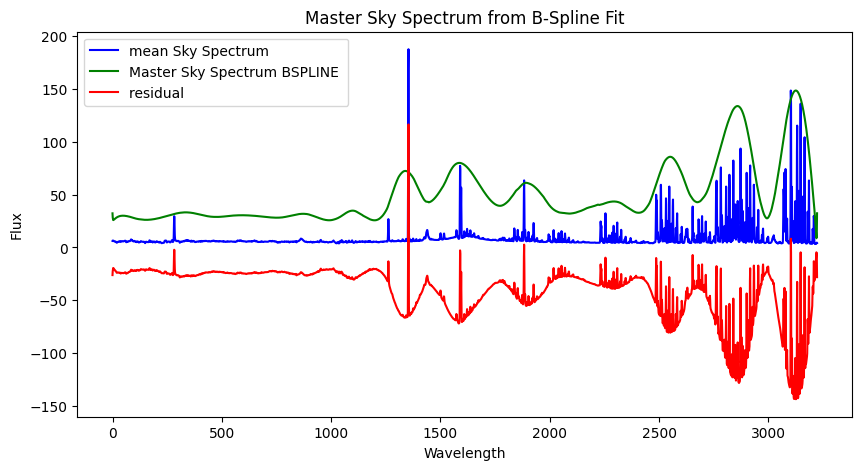

In [25]:
import numpy as np
from scipy.interpolate import LSQUnivariateSpline
import matplotlib.pyplot as plt


spectra=spectra_filtered_list['sky']


# Define knot points
num_knots = 30  
knots = np.linspace(wavelength[5], wavelength[-5], num_knots) 

spline_fits = []
for i in range(spectra.shape[0]):
    spline = LSQUnivariateSpline(wavelength, spectra[i, :], t=knots)
    spline_fits.append(spline(wavelength))

master_sky_spectrum = np.median(spline_fits, axis=0)

#rescaling
#scaling_factor = mean_observed_sky / mean_sky_model
scaling_factor=np.max(mean_sky[1500:])/np.max(master_sky_spectrum[1500:])
scaled_sky_model = (scaling_factor) * master_sky_spectrum

# Plot the result
plt.figure(figsize=(10, 5))
#plt.plot(wavelength, mean_sky, label='Master Sky Spectrum', color='red')
#plt.plot(wavelength, master_sky_spectrum, label='Master Sky Spectrum', color='blue')
plt.plot( mean_sky, label='mean Sky Spectrum', color='blue')
plt.plot(scaled_sky_model, label='Master Sky Spectrum BSPLINE ', color='green')
plt.plot(mean_sky-scaled_sky_model, label='residual ', color='red')

plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.title('Master Sky Spectrum from B-Spline Fit')
plt.legend()
plt.show()


In [23]:



residual= (spectra-scaled_sky_model)
#from scipy.ndimage import median_filter
#filtered_arr = median_filter(residual, size=30)
#residual[residual<-5]=-5